# CNN Model Building and Training Notebook

### This code is in developmental stage. Later will be translated for Azure Cloud implementation. 

### To use this code, dataset has been stored in google drive and gdrive path is mounted for use in notebook. 

In [1]:
try:
  import os, sys 
  #to be able to interact with Google Drive's operating system
  from google.colab import drive 
  #drive is a module that allows us use Python to interact with google drive
  drive.mount('/content/gdrive') 
  #mounting google drive allows us to work with its contents
  nb_path = '/content/notebooks'
  os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
  sys.path.insert(0, nb_path)  # or append(nb_path)
  #The last three lines are what changes the path of the file.
except:
  print("Drive already mounted and ready to use!")

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [4]:
# Storing all required paths for later use

main_cwd = r'/content/gdrive/My Drive/Colab Notebooks/CNN_Medical_Imaging'
model_cwd = os.path.join(main_cwd, "Models")
dataset_cwd = os.path.join(main_cwd, "Datasets")
image_data_cwd = os.path.join(main_cwd, "Saved Image Data Arrays")
saved_models_cwd = os.path.join(main_cwd, "Saved_models")
model_checkpoints_cwd = os.path.join(main_cwd, "Model_check_points")
healthy_bones_dataset_cwd = os.path.join(dataset_cwd, "Healthy_bones")
fractured_bones_dataset_cwd = os.path.join(dataset_cwd, "Fractured_bones")
beyond_repair_bones_dataset_cwd = os.path.join(dataset_cwd, "Bones_beyond_repair")
train_test_valid_x_image_data = os.path.join(image_data_cwd, "three_classes", "train_test_valid_x_images_compressed_data_array_224.npz")
train_test_valid_y_labels_data = os.path.join(image_data_cwd, "three_classes", "train_test_valid_y_labels_compressed_array_224.npy")


In [5]:
# Importing required libraries

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import warnings
import cv2
import re
import os


In [6]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

## Helper functions

In [7]:
def get_cwd_files(path):

  ignore_files = [".gitkeep", ".gitignore"]
  path_files = os.listdir(path)
  path_files = [file for file in path_files if file not in ignore_files]

  return path_files

In [8]:
def get_image_data(image_data_process_directory, image_resize_value):

  # Classes for our prediction
  classification_classes = ["Healthy_bones", "Fractured_bones", "Bones_beyond_repair"]
  classification_classes_dict = {1:"Healthy_bones", 2:"Fractured_bones", 3:"Bones_beyond_repair"}
  # Set Image size
  img_size = image_resize_value

  #flag_counter = 0
  # Processing image to array
  #data = []
  image_data = []
  label_data = []
  for each_class in classification_classes:
    #flag_counter = 0
    class_category_number = classification_classes.index(each_class)
    bone_class_img_path = os.path.join(image_data_process_directory, each_class)
    #print(bone_class_img_path)
    bone_images = get_cwd_files(bone_class_img_path)
    for bone_image in bone_images:
      
      '''
      if flag_counter == 50:
        break
      flag_counter += 1'''

      bone_image_path = os.path.join(bone_class_img_path, bone_image)
      #print(bone_image_path)
      try:
        x_ray_image = load_img(bone_image_path, target_size=(img_size, img_size))
        x_ray_image = img_to_array(x_ray_image)
        image_data.append(x_ray_image)
        label_data.append(class_category_number)
        #print(x_ray_image.shape)
        #data.append([x_ray_image, class_category_number])
      except:
        print("Some error occured in fetching data!")

  
  #data = np.array(data)
  image_data = np.array(image_data)
  label_data = np.array(label_data) 
  
  return image_data, label_data  


## Main Program

Pre processing images to arrays and storing them is done only for the first run and for subsequent runs load the saved array images files for further work to reduce time.

In [9]:
# Processing train data images
#train_test_valid_x, train_test_valid_y = get_image_data(dataset_cwd, image_resize_value = 224)

## Storing values of the image processed array data in csv files

In [10]:
# Storing Train_test_valid image array values

# For train_test_valid_x compressed values
#np.savez_compressed("train_test_valid_x_images_compressed_data_array_224", train_test_valid_array = train_test_valid_x)

# For train_test_valid_y compressed values
#np.save("train_test_valid_y_labels_compressed_array_224", train_test_valid_y)


## Loading Image arrays from the saved files

In [11]:
# Loading Train image compressed array values

# For train_x values
model_train_test_valid_x = np.load(train_test_valid_x_image_data)["train_test_valid_array"]

# For train_y values
model_train_test_valid_y = np.load(train_test_valid_y_labels_data)

In [12]:
# Creating train and test dataset
train_valid_x, model_test_x, train_valid_y, model_test_y = train_test_split(model_train_test_valid_x, model_train_test_valid_y, random_state = 42, stratify = model_train_test_valid_y, test_size = 0.10)

In [13]:
# Creating train and test dataset
model_train_x, model_valid_x, model_train_y, model_valid_y = train_test_split(train_valid_x, train_valid_y, random_state = 42, stratify = train_valid_y, test_size = 0.15)

In [14]:
# Removing specific variables from runtime to save RAM
del model_train_test_valid_x, model_train_test_valid_y, train_valid_x, train_valid_y

In [15]:
# Normalizing values
model_train_x, model_train_y = model_train_x/255, model_train_y
model_test_x, model_test_y = model_test_x/255, model_test_y
model_valid_x, model_valid_y = model_valid_x/255, model_valid_y

## Hyperparameters for Data Augmentation

In [23]:
# Hyperparameters for Imagedatagenerator
model_shear_range = 0.2           # Image angular deformation range
model_zoom_range = 0.2            # Image zoom in/out range
model_brightness_range = [0.9,1.2]    # Brightness change range (0.9 to 1.2)
model_rotation_range = 30         # Angular change range
model_width_shift_range = 0.2     # Horizontal shift range
model_height_shift_range = 0.2    # Vertical shift range


### Data Augmentation Initilization


In [24]:
# Image generator for training images
train_gen = ImageDataGenerator(
    rotation_range = model_rotation_range,
    #brightness_range = model_brightness_range,
    #width_shift_range = model_width_shift_range,
    #height_shift_range = model_height_shift_range,
    #zoom_range = model_zoom_range,
    #shear_range = model_shear_range,
    horizontal_flip = True,
    vertical_flip=True,
    #fill_mode = "constant",
    #cval = 0.0  # fill with black color for any blank spaces present after image shift
)

# Image generator fo validation images
valid_gen = ImageDataGenerator()  # No parameters

### Data Augmentation

In [25]:
# Fitting image generator models to datasets 
train_gen.fit(model_train_x)
valid_gen.fit(model_valid_x)

# Creating iter variables for model compile flow
train_iter = train_gen.flow(model_train_x, model_train_y, batch_size = 32)
valid_iter = valid_gen.flow(model_valid_x, model_valid_y, batch_size = 8, shuffle = False)

## Hyperparameters for model building



In [26]:
# Model hyperparameters
model_accuracy = ["acc", "mse"]

# When using all 3 classes (healthy bones, fractured bones and bones beyond repair), then this categorical cross entropy loss
# Using Sparse categorical instead of just categorical as the classes here are considered to be mutually exclusive and hence sparse categorical
# If the sample could have multiple classes or labels (not completely mutually exclusive), then use categorical.
model_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Now as we are working with 2 class currently (healthy bones and fractured bones) we will use binary crossentrophy loss
#model_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Model checkpoints directory as per version of models created (This is version 1)
model_checkpoints_dir = os.path.join(model_checkpoints_cwd, "v1")

model_lr = 0.001  # 0.000001
model_optimizer = Adam(learning_rate = model_lr)
#model_optimizer = RMSprop(learning_rate = model_lr)
model_epochs = 100
model_callbacks = [
                ModelCheckpoint(model_checkpoints_dir, monitor = "val_loss", save_best_only=True, mode="min",options=None),
                EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=8,verbose=1, mode="min",restore_best_weights=True),
                ReduceLROnPlateau(monitor="val_loss",min_delta=1e-4, factor=0.1, patience=3, verbose=1, min_lr=0.0001,mode="min")                
                ]

# After an intial run, we understood as the classes are heavily imbalanced (maybe due to imbalanced dataset or lack of features from the other unpredicted class),
# We use assigning class weights option to let our model train from all classes uniquely, later we will also try to increase our dataset for the better classification
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(model_train_y), y = model_train_y)
model_class_weights = dict(zip(np.unique(model_train_y), weights))

### Model Building

In [27]:
# CNN Architecture
### adding sequential model ,add a bunch of conv,maxpool,dropout ,flatten it and then eventually add dense layers for all classes.

cnn_model = Sequential()
cnn_model.add(Conv2D(64, 7,padding="same", activation="relu", input_shape=(224,224,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D())  # Default is (2x2)

# Consider below two cnn layers as a single cnn feature layer
cnn_model.add(Conv2D(128, 3, padding="same", activation="relu", kernel_initializer = 'he_uniform'))
cnn_model.add(Conv2D(128, 3, padding="same", activation="relu", kernel_initializer = 'he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D())

# Consider below two cnn layers as a single cnn feature layer
cnn_model.add(Conv2D(256, 3, padding="same", activation="relu", kernel_initializer = 'he_uniform'))
cnn_model.add(Conv2D(256, 3, padding="same", activation="relu", kernel_initializer = 'he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D())
cnn_model.add(Dropout(0.4))  # To prevent overfitting


cnn_model.add(Flatten())
cnn_model.add(Dense(512, kernel_initializer = 'he_uniform', use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(128, kernel_initializer = 'he_uniform', use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(3, activation="softmax"))  # When 3 classes together will be used, use - 
                                               # cnn_model.add(Dense(3, activation="softmax"))

cnn_model.compile(optimizer = model_optimizer, loss = model_loss, metrics = model_accuracy)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 128)    5

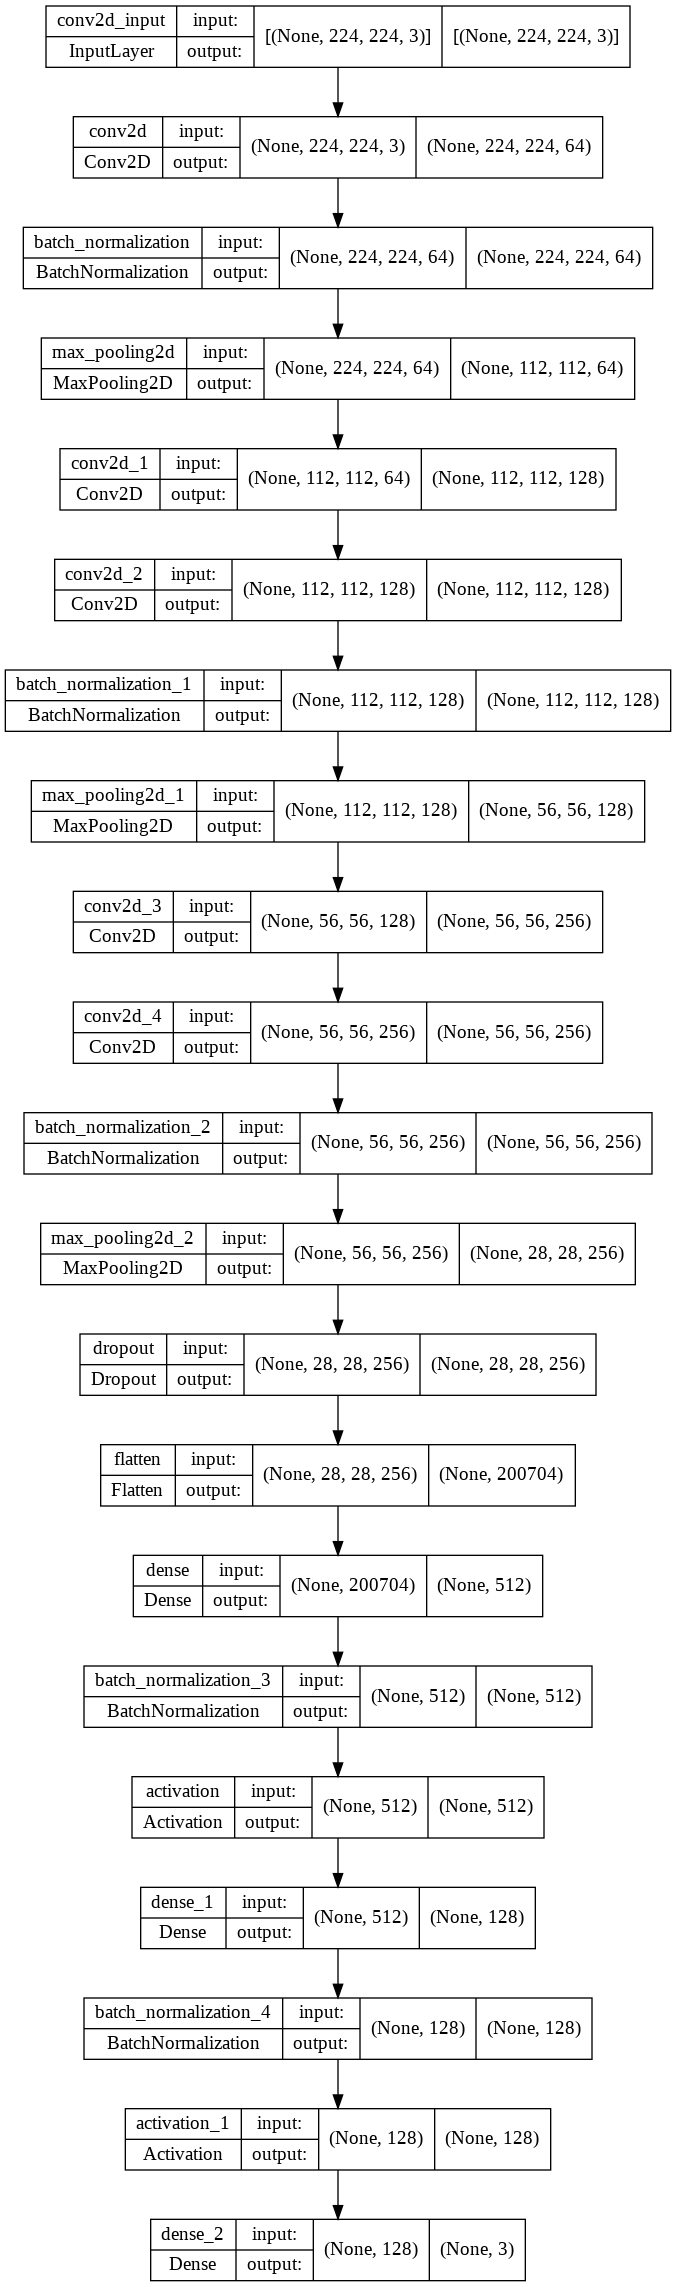

In [28]:
# Model Plot
plot_model(cnn_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [29]:
# Model fit
history = cnn_model.fit(train_iter, validation_data=valid_iter, steps_per_epoch=len(model_train_x)/32, epochs=model_epochs, callbacks=model_callbacks)

Epoch 1/100
88/88 [==============================] - 83s 765ms/step - loss: 0.8690 - acc: 0.5501 - mse: 0.8724 - val_loss: 1.5888 - val_acc: 0.3980 - val_mse: 0.8927 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 65s 728ms/step - loss: 0.7723 - acc: 0.5791 - mse: 0.8704 - val_loss: 1.3543 - val_acc: 0.4240 - val_mse: 0.8638 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 67s 754ms/step - loss: 0.7454 - acc: 0.6173 - mse: 0.8753 - val_loss: 1.3663 - val_acc: 0.4220 - val_mse: 0.8840 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 63s 710ms/step - loss: 0.7276 - acc: 0.6226 - mse: 0.8772 - val_loss: 0.7822 - val_acc: 0.5700 - val_mse: 0.8684 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 64s 722ms/step - loss: 0.7242 - acc: 0.6173 - mse: 0.8787 - val_loss: 1.7719 - val_acc: 0.5000 - val_mse: 0.9163 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 52s 591ms/step - loss: 0.7151 - acc: 0.6212 - mse: 0

In [34]:
# Save model
keras.models.save_model(cnn_model, "cnn_model_v3.h5", save_format="h5")

<Figure size 432x288 with 0 Axes>

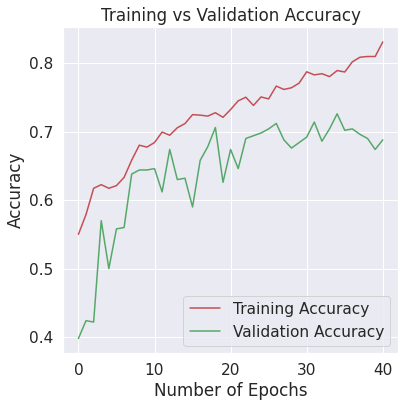

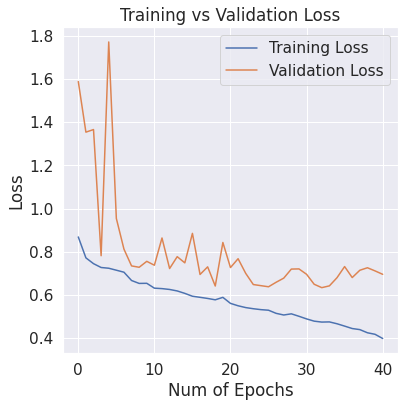

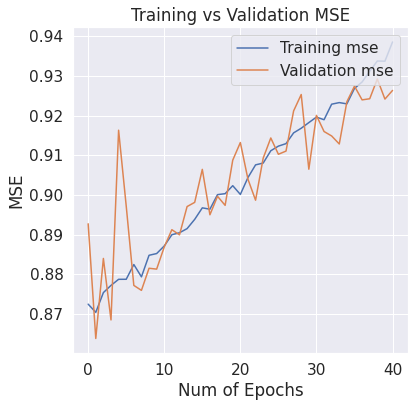

In [35]:
# Model History Plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mse']
val_mse = history.history['val_mse']
epochs_range = range(len(history.history['loss']))

plt.figure(0)
plt.figure(figsize=(6, 6))
plt.plot(epochs_range, acc, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'g', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.figure(1)
plt.figure(figsize=(6, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.figure(2)
plt.figure(figsize=(6, 6))
plt.plot(epochs_range, mse, label='Training mse')
plt.plot(epochs_range, val_mse, label='Validation mse')
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.legend(loc='upper right')
plt.title('Training vs Validation MSE')

plt.show()

## Prediction Stats

In [36]:
# Finding Prediction Error

# Since for now we are dealing with a binary classifciation problem (healthy bones and fractured bones), we use the following method
# Later when we continue working with all 3 classes (healthy bones, fractured bones and bones beyond repair), we will change the below maths accordingly
model_test_prediction_labels = cnn_model.predict(model_test_x)
model_test_prediction_list = []

for label_prediction in model_test_prediction_labels:
    model_test_prediction_list.append(np.argmax(label_prediction))


prediction_error = np.sum(np.not_equal(model_test_prediction_list, list(model_test_y))) / model_test_y.shape[0]
print(f"The prediction error for the model is {prediction_error}")


The prediction error for the model is 0.2810810810810811


#### The model prediction error should be close to zero. The above value will show how much the model needs more tuning and optimization in order to have prediction error closer to zero.

## Metric Stats

Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       150
           1       0.70      0.53      0.60       141
           2       0.76      0.81      0.79        79

    accuracy                           0.72       370
   macro avg       0.72      0.73      0.72       370
weighted avg       0.72      0.72      0.71       370

Confusion Matrix: 


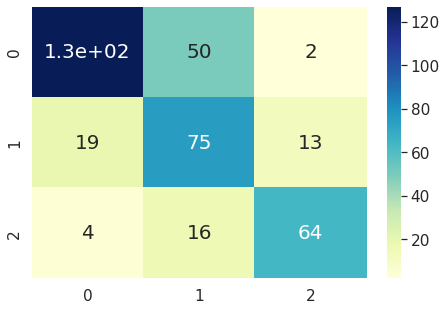

In [37]:
# Classification Report:
print('Classification Report: ')
print(classification_report(list(model_test_y), model_test_prediction_list, target_names=["0","1", "2"]))

# Confusion Matrix
print('Confusion Matrix: ')
cm = confusion_matrix(model_test_prediction_list, list(model_test_y))
plt.figure(figsize = (7.5,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()